# American Sign Language's Alphabet Recognition
Authors: Nikhil Gautam, Paolo Guarino

### 1. Adopted Libraries

In [24]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

### 2. Dataset Upload and Features Extraction

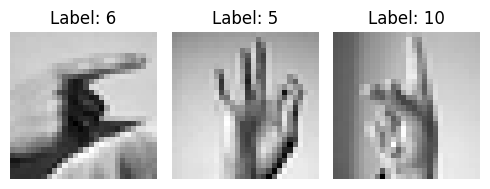

Dataset dimension: (34627, 784), where 784 = 28x28 which is the dimension of each image sample.
Classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Number of classes: 24
X_train: (27701, 784)
X_test: (6926, 784)


In [25]:
# Load the sign language dataset
sign = pd.read_csv("sign_mnist.csv")
#print(sign.head)

# Increase figure size and DPI for better image quality
plt.figure(figsize=(5, 5), dpi=100)
#sign = pd.read_csv("sign_mnist.csv")

# Print the first three images from dataset
for i in range(3):
    image = sign.iloc[i, 1:].values.reshape(28, 28)  # Reshape the image to 28x28
    label = sign.iloc[i, 0]  # Get the label for the image

    plt.subplot(1, 3, i + 1)  # Create subplots for each image
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')  # Remove axis ticks and labels

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

# Split the dataset into features (X) and labels (y)
X = sign.drop('label', axis=1).values
y = sign['label'].values
print("Dataset dimension: " + str(X.shape) + ", where 784 = 28x28 which is the dimension of each image sample.")

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Classes: " + str(np.unique(y)))
num_classes = len(np.unique(y))
print("Number of classes: " + str(num_classes))
print('X_train: ' + str(X_train.shape))
print('X_test: '+ str(X_test.shape))

# Standardize the features using StandardScaler
# The fit_transform() method is used to compute the mean and standard deviation of the training data (X_train) and standardize it by subtracting the mean and dividing by the standard deviation.
# The transform() method is then used to standardize the testing data (X_test) using the mean and standard deviation computed from the training data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for CNN input (assuming the images are grayscale)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)
# Convert the labels to categorical form
y_train = y_train - 1
y_train_cat = to_categorical(y_train, num_classes)
y_test = y_test - 1
y_test_cat = to_categorical(y_test, num_classes)

<Axes: xlabel='label', ylabel='count'>

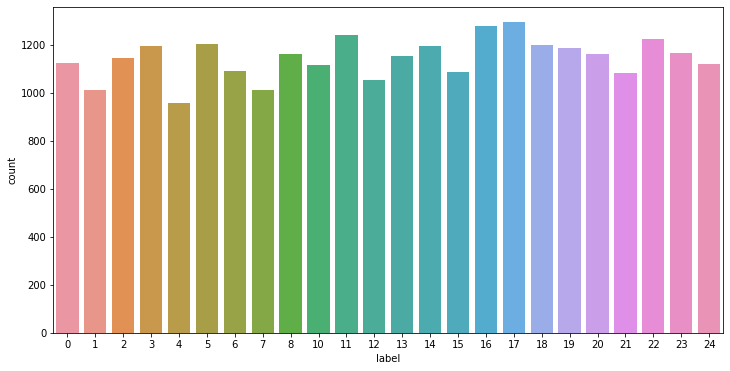

In [31]:
# Show the distribution of train data w.r.t. the classes.
Train_data = pd.read_csv('sign_mnist_train.csv')
plt.figure(figsize=(12,6))
sns.countplot(x="label", data=Train_data)

<Axes: xlabel='label', ylabel='count'>

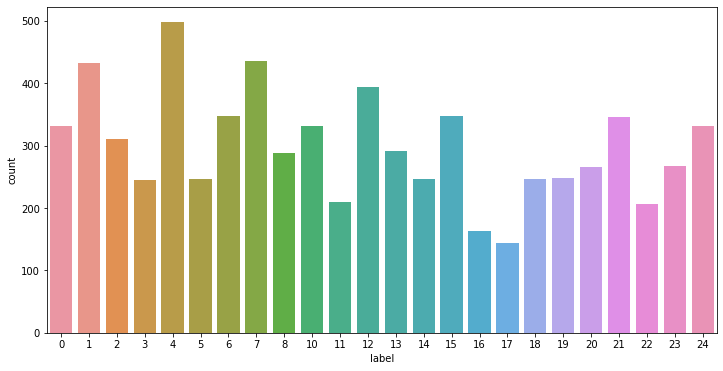

In [32]:
# Show the distribution of test data w.r.t. the classes.
Test_data = pd.read_csv('sign_mnist_test.csv')
plt.figure(figsize=(12,6))
sns.countplot(x="label", data=Test_data)

### 3. Feature Space Dimensionality Reduction

In [7]:
# Apply feature extraction using PCA 
pca = PCA(n_components=40)  # Number of components to keep
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print('X_train: ' + str(X_train_pca.shape))
print('X_test: '+ str(X_test_pca.shape))

# Check the variances of the 40 selected components.
X_train_var = np.var(X_train_pca)
X_train_var = sum(pca.explained_variance_ratio_)
print("X_train_var after PCA with 40 components: "+str(X_train_var))

# Reduce the number of components to 3.
pca = PCA(n_components=3)  # Number of components to keep
X_train_pca3 = pca.fit_transform(X_train)
X_test_pca3 = pca.transform(X_test)
print('X_train: ' + str(X_train_pca3.shape))
print('X_test: '+ str(X_test_pca3.shape))

# Check the variances of the 3 selected components.
X_train_pca3_var = np.var(X_train_pca3)
X_train_pca3_var = sum(pca.explained_variance_ratio_)
#print(pca.explained_variance_ratio_)
print("X_train_var after PCA with 3 components: "+str(X_train_pca3_var) + \
      " as expected, there is a high loss of information w.r.t pca using 40 components")

# Print a 2D representation of data
#print(np.unique(y_train))
#plot = plt.scatter(X_train_pca3[:,0], X_train_pca3[:,1], c=y_train)
#plt.show()

# Print a 3D representation of data
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
#ax.scatter(X_train_pca3[:,0], X_train_pca3[:,1], X_train_pca3[:,2], c=y_train)
#plt.show()

X_train: (27701, 40)
X_test: (6926, 40)
X_train_var after PCA with 40 components: 0.8671240120442532
X_train: (27701, 3)
X_test: (6926, 3)
X_train_var after PCA with 3 components: 0.5126128083790911 as expected, there is a high loss of information w.r.t pca using 40 components


### 4. KNN with PCA

In [8]:
# K-Nearest Neighbors (K-NN) with PCA
# K = 1, 3, 5, 7, 9, 11, math.sqrt(X_train.shape[0])
# DISTANCE METRIC: DM = EUCLIDEAN, MINKOWSKI, MANHATTAN, COSINE

K = [3, 5, 7, 9, 11, int(math.sqrt(X_train.shape[0]))]
DM = ['euclidean', 'manhattan', 'cosine']
for i in DM:
    for k in K:
        knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=i)
        knn_classifier.fit(X_train_pca, y_train)
        knn_pred = knn_classifier.predict(X_test_pca)
        knn_accuracy = accuracy_score(y_test, knn_pred)
        knn_precision = precision_score(y_test, knn_pred, average='macro')
        knn_recall = recall_score(y_test, knn_pred, average='macro')
        knn_cm = confusion_matrix(y_test, knn_pred)

        print("\nK-Nearest Neighbors (K-NN) with PCA, K = " + str(k) + ", DISTANCE METRIC = " + i + ", Results:")
        print("Accuracy:", knn_accuracy)
        print("Precision:", knn_precision)
        print("Recall:", knn_recall)

#print("Confusion Matrix:")
#disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
#disp.plot()
#plt.show()


K-Nearest Neighbors (K-NN) with PCA, K = 3, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9914813745307537
Precision: 0.9914001368276648
Recall: 0.9913774790401689

K-Nearest Neighbors (K-NN) with PCA, K = 5, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9867167196072769
Precision: 0.9866578743241313
Recall: 0.986551257808066

K-Nearest Neighbors (K-NN) with PCA, K = 7, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9820964481663298
Precision: 0.9821061076955931
Recall: 0.9818913292297656

K-Nearest Neighbors (K-NN) with PCA, K = 9, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9755991914524978
Precision: 0.9756666816078431
Recall: 0.9752843576258967

K-Nearest Neighbors (K-NN) with PCA, K = 11, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9705457695639619
Precision: 0.9705282614924284
Recall: 0.9701459641296927

K-Nearest Neighbors (K-NN) with PCA, K = 166, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.7419867167196073
Precision: 0.7508268106413958
Recall: 0.7

### 5. KNN without PCA

In [9]:
# K-Nearest Neighbors (K-NN) NO PCA
# K = 1, 3, 5, 7, 9, 11, math.sqrt(X_train.shape[0])
# DISTANCE METRIC: DM = EUCLIDEAN, MINKOWSKI, MANHATTAN, COSINE

K = [3, 5, 7, 9, 11, int(math.sqrt(X_train.shape[0]))]
DM = ['euclidean', 'manhattan', 'cosine']
for i in DM:
    for k in K:
        knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=i)
        knn_classifier.fit(X_train, y_train)
        knn_pred = knn_classifier.predict(X_test)
        knn_accuracy = accuracy_score(y_test, knn_pred)
        knn_precision = precision_score(y_test, knn_pred, average='macro')
        knn_recall = recall_score(y_test, knn_pred, average='macro')
        knn_cm = confusion_matrix(y_test, knn_pred)

        print("\nK-Nearest Neighbors (K-NN), K = " + str(k) + ", DISTANCE METRIC = " + i + ", Results:")
        print("Accuracy:", knn_accuracy)
        print("Precision:", knn_precision)
        print("Recall:", knn_recall)

#print("Confusion Matrix:")
#disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
#disp.plot()
#plt.show()


K-Nearest Neighbors (K-NN), K = 3, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9972567138319376
Precision: 0.9972270035243103
Recall: 0.9972464179937922

K-Nearest Neighbors (K-NN), K = 5, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9955241120415824
Precision: 0.9955082657022358
Recall: 0.9954265098141762

K-Nearest Neighbors (K-NN), K = 7, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9926364423909905
Precision: 0.9925151696217759
Recall: 0.9925568904030673

K-Nearest Neighbors (K-NN), K = 9, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9898931562229281
Precision: 0.9898470714972746
Recall: 0.9897430386402597

K-Nearest Neighbors (K-NN), K = 11, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.9875830205024545
Precision: 0.9875265704981798
Recall: 0.9874439564989962

K-Nearest Neighbors (K-NN), K = 166, DISTANCE METRIC = euclidean, Results:
Accuracy: 0.7529598613918568
Precision: 0.7757857974702856
Recall: 0.7509287981606351

K-Nearest Neighbors (K-NN), K = 3, D

### 6. SVM with PCA

In [10]:
# Support Vector Machines (SVM) with PCA: One-vs-Rest approach
# KERNEL FUNCION: KF = linear, polynomial, rbf, sigmoid
KF = ['linear', 'poly', 'rbf', 'sigmoid']
for i in KF:
    svm_classifier = SVC(kernel=i, decision_function_shape='ovr')
    svm_classifier.fit(X_train_pca, y_train)
    svm_pred = svm_classifier.predict(X_test_pca)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_precision = precision_score(y_test, svm_pred, average='macro')
    svm_recall = recall_score(y_test, svm_pred, average='macro')
    svm_cm = confusion_matrix(y_test, svm_pred)

    print("\nSupport Vector Machines (SVM) with PCA, KERNEL FUNCTION: " + i + ", Results:")
    print("Accuracy:", svm_accuracy)
    print("Precision:", svm_precision)
    print("Recall:", svm_recall)

#print("Confusion Matrix:")
#disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
#disp.plot()
#plt.show()


Support Vector Machines (SVM) with PCA, KERNEL FUNCTION: linear, Results:
Accuracy: 0.9997112330349408
Precision: 0.9997060543472851
Recall: 0.9997140205473539

Support Vector Machines (SVM) with PCA, KERNEL FUNCTION: poly, Results:
Accuracy: 0.9563961882760612
Precision: 0.962285180553517
Recall: 0.9561303066244163

Support Vector Machines (SVM) with PCA, KERNEL FUNCTION: rbf, Results:
Accuracy: 0.9950909615939937
Precision: 0.9952180131165386
Recall: 0.9950655872828064

Support Vector Machines (SVM) with PCA, KERNEL FUNCTION: sigmoid, Results:
Accuracy: 0.3559052844354606
Precision: 0.4245883874210001
Recall: 0.35381259611668137


### 7. SVM without PCA

In [11]:
# Support Vector Machines (SVM) NO PCA: One-vs-Rest approach
# KERNEL FUNCION: KF = linear, polynomial, rbf, sigmoid
KF = ['linear', 'poly', 'rbf', 'sigmoid']
for i in KF:
    svm_classifier = SVC(kernel=i, decision_function_shape='ovr')
    svm_classifier.fit(X_train, y_train)
    svm_pred = svm_classifier.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_precision = precision_score(y_test, svm_pred, average='macro')
    svm_recall = recall_score(y_test, svm_pred, average='macro')
    svm_cm = confusion_matrix(y_test, svm_pred)

    print("\nSupport Vector Machines (SVM), KERNEL FUNCTION: " + i + ", Results:")
    print("Accuracy:", svm_accuracy)
    print("Precision:", svm_precision)
    print("Recall:", svm_recall)

#print("Confusion Matrix:")
#disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
#disp.plot()
#plt.show()


Support Vector Machines (SVM), KERNEL FUNCTION: linear, Results:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Support Vector Machines (SVM), KERNEL FUNCTION: poly, Results:
Accuracy: 0.9826739820964482
Precision: 0.9845939428768533
Recall: 0.9826492233107317

Support Vector Machines (SVM), KERNEL FUNCTION: rbf, Results:
Accuracy: 0.9998556165174703
Precision: 0.9998511904761905
Recall: 0.9998468137254902

Support Vector Machines (SVM), KERNEL FUNCTION: sigmoid, Results:
Accuracy: 0.4298296274906151
Precision: 0.5091360534591578
Recall: 0.4269283386638903


### 8. CNN: ReLU as Activation Function

Epoch 1/10
174/174 [==============================] - 8s 39ms/step - loss: 0.8313 - accuracy: 0.7578 - val_loss: 0.1767 - val_accuracy: 0.9531
Epoch 2/10
174/174 [==============================] - 7s 39ms/step - loss: 0.0552 - accuracy: 0.9902 - val_loss: 0.0260 - val_accuracy: 0.9969
Epoch 3/10
174/174 [==============================] - 7s 38ms/step - loss: 0.0081 - accuracy: 0.9999 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 4/10
174/174 [==============================] - 7s 39ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9998
Epoch 5/10
174/174 [==============================] - 7s 38ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9998
Epoch 6/10
174/174 [==============================] - 7s 42ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/10
174/174 [==============================] - 6s 34ms/step - loss: 7.5688e-04 - accuracy: 1.0000 - val_loss: 9.7999e-04 - val_accuracy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


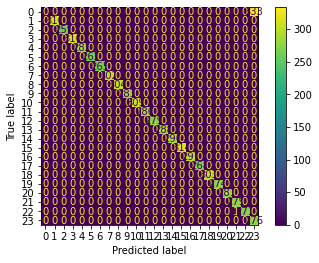

<Figure size 3600x3600 with 0 Axes>

In [16]:
# Convolutional Neural Networks (CNN) model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Performs forward pass and backward pass.
model.fit(np.array(X_train_cnn), np.array(y_train_cat), batch_size=128, epochs=10, validation_split=0.2)

cnn_pred = model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)
cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
cnn_precision = precision_score(y_test, cnn_pred_classes, average='macro')
cnn_recall = recall_score(y_test, cnn_pred_classes, average='macro')
cnn_cm = confusion_matrix(y_test, cnn_pred_classes)

print("\nConvolutional Neural Network (CNN) Results:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("Confusion Matrix:")
print(cnn_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm)
disp.plot()
plt.figure(figsize=(50,50))
plt.show()

### 9. CNN: ELU as Activation Function

Epoch 1/10
174/174 [==============================] - 7s 36ms/step - loss: 0.5725 - accuracy: 0.8330 - val_loss: 0.0537 - val_accuracy: 0.9919
Epoch 2/10
174/174 [==============================] - 6s 35ms/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 3/10
174/174 [==============================] - 6s 35ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/10
174/174 [==============================] - 6s 35ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/10
174/174 [==============================] - 6s 35ms/step - loss: 6.6802e-04 - accuracy: 1.0000 - val_loss: 9.0828e-04 - val_accuracy: 1.0000
Epoch 6/10
174/174 [==============================] - 6s 35ms/step - loss: 4.5583e-04 - accuracy: 1.0000 - val_loss: 6.0011e-04 - val_accuracy: 1.0000
Epoch 7/10
174/174 [==============================] - 6s 35ms/step - loss: 3.0945e-04 - accuracy: 1.0000 - val_loss: 5.2605e-0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


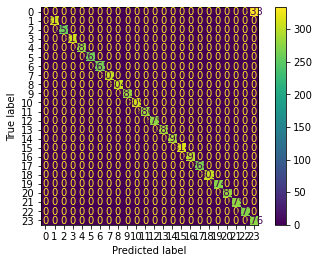

<Figure size 3600x3600 with 0 Axes>

In [17]:
# Convolutional Neural Networks (CNN) model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='elu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Performs forward pass and backward pass.
model.fit(np.array(X_train_cnn), np.array(y_train_cat), batch_size=128, epochs=10, validation_split=0.2)

cnn_pred = model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)
cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
cnn_precision = precision_score(y_test, cnn_pred_classes, average='macro')
cnn_recall = recall_score(y_test, cnn_pred_classes, average='macro')
cnn_cm = confusion_matrix(y_test, cnn_pred_classes)

print("\nConvolutional Neural Network (CNN) Results:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("Confusion Matrix:")
print(cnn_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm)
disp.plot()
plt.figure(figsize=(50,50))
plt.show()

### 10. CNN: SIGMOID as Activation Function

Epoch 1/10
174/174 [==============================] - 6s 34ms/step - loss: 2.7294 - accuracy: 0.1998 - val_loss: 1.8866 - val_accuracy: 0.4613
Epoch 2/10
174/174 [==============================] - 6s 36ms/step - loss: 1.4177 - accuracy: 0.6108 - val_loss: 1.0711 - val_accuracy: 0.7069
Epoch 3/10
174/174 [==============================] - 6s 33ms/step - loss: 0.8396 - accuracy: 0.7901 - val_loss: 0.6585 - val_accuracy: 0.8515
Epoch 4/10
174/174 [==============================] - 6s 35ms/step - loss: 0.5201 - accuracy: 0.8924 - val_loss: 0.4190 - val_accuracy: 0.9237
Epoch 5/10
174/174 [==============================] - 6s 35ms/step - loss: 0.3234 - accuracy: 0.9510 - val_loss: 0.2633 - val_accuracy: 0.9670
Epoch 6/10
174/174 [==============================] - 6s 35ms/step - loss: 0.2069 - accuracy: 0.9785 - val_loss: 0.1757 - val_accuracy: 0.9811
Epoch 7/10
174/174 [==============================] - 6s 35ms/step - loss: 0.1334 - accuracy: 0.9913 - val_loss: 0.1179 - val_accuracy: 0.9933

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


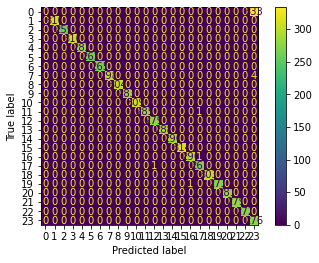

<Figure size 3600x3600 with 0 Axes>

In [14]:
# Convolutional Neural Networks (CNN) model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Performs forward pass and backward pass.
model.fit(np.array(X_train_cnn), np.array(y_train_cat), batch_size=128, epochs=10, validation_split=0.2)

cnn_pred = model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)
cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
cnn_precision = precision_score(y_test, cnn_pred_classes, average='macro')
cnn_recall = recall_score(y_test, cnn_pred_classes, average='macro')
cnn_cm = confusion_matrix(y_test, cnn_pred_classes)

print("\nConvolutional Neural Network (CNN) Results:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("Confusion Matrix:")
print(cnn_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm)
disp.plot()
plt.figure(figsize=(50,50))
plt.show()

### 11. CNN: TANH as Activation Function

Epoch 1/10
174/174 [==============================] - 7s 35ms/step - loss: 0.6694 - accuracy: 0.8343 - val_loss: 0.1103 - val_accuracy: 0.9933
Epoch 2/10
174/174 [==============================] - 6s 36ms/step - loss: 0.0478 - accuracy: 0.9988 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 3/10
174/174 [==============================] - 6s 36ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 4/10
174/174 [==============================] - 6s 36ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 5/10
174/174 [==============================] - 6s 36ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 6/10
174/174 [==============================] - 6s 36ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 7/10
174/174 [==============================] - 6s 36ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


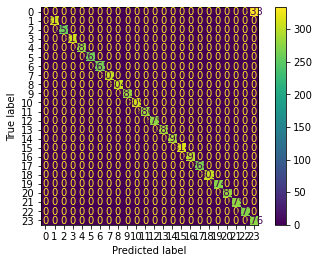

<Figure size 3600x3600 with 0 Axes>

In [15]:
# Convolutional Neural Networks (CNN) model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Performs forward pass and backward pass.
model.fit(np.array(X_train_cnn), np.array(y_train_cat), batch_size=128, epochs=10, validation_split=0.2)

cnn_pred = model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)
cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
cnn_precision = precision_score(y_test, cnn_pred_classes, average='macro')
cnn_recall = recall_score(y_test, cnn_pred_classes, average='macro')
cnn_cm = confusion_matrix(y_test, cnn_pred_classes)

print("\nConvolutional Neural Network (CNN) Results:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("Confusion Matrix:")
print(cnn_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm)
disp.plot()
plt.figure(figsize=(50,50))
plt.show()